In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import time
import matplotlib.pyplot as plt



In [2]:
# Load MNIST (and prepare 3-channel version for pretrained CNNs)
transform_gray = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_rgb = transforms.Compose([
    transforms.Resize((224, 224)),     # pretrained models expect 224x224
    transforms.Grayscale(num_output_channels=3),  # convert 1→3 channels
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_gray)
test_mnist  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_gray)
test_mnist_rgb = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_rgb)

train_loader = DataLoader(train_mnist, batch_size=128, shuffle=True)
test_loader_gray = DataLoader(test_mnist, batch_size=256, shuffle=False)
test_loader_rgb = DataLoader(test_mnist_rgb, batch_size=64, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")



Using device: cpu


In [3]:
# Define CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32*14*14, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(-1, 32*14*14)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Train Simple CNN
cnn = SimpleCNN().to(device)
optimizer = torch.optim.Adam(cnn.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

epochs = 5
for epoch in range(epochs):
    cnn.train()
    total_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        out = cnn(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss = {total_loss/len(train_loader):.4f}")



Epoch 1/5, Loss = 0.3673
Epoch 2/5, Loss = 0.1024
Epoch 3/5, Loss = 0.0704
Epoch 4/5, Loss = 0.0567
Epoch 5/5, Loss = 0.0478


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\siddh/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 21.6MB/s]


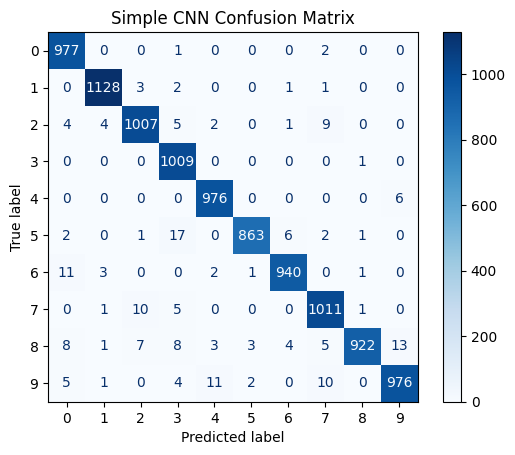

Simple CNN Accuracy: 0.9809, F1: 0.9807, Inference Time: 2.07s


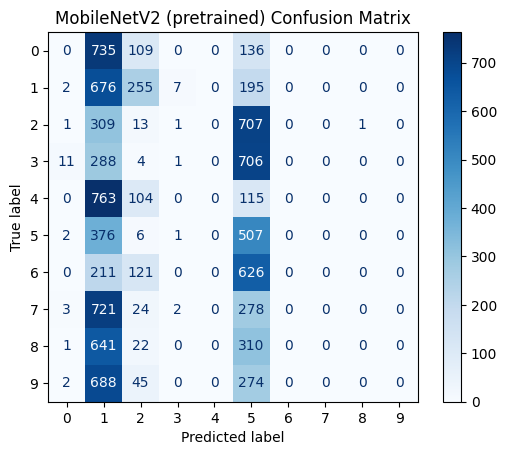

MobileNetV2 (pretrained) Accuracy: 0.1197, F1: 0.0437, Inference Time: 243.41s


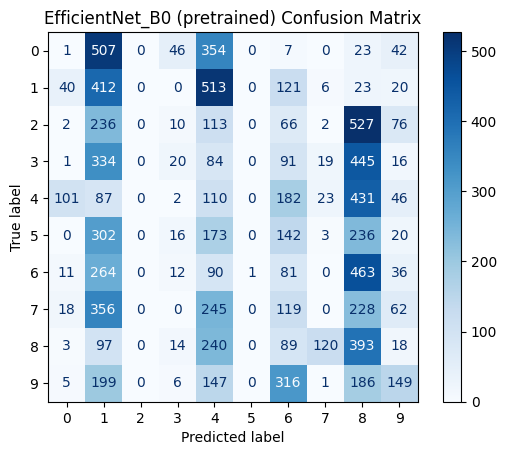

EfficientNet_B0 (pretrained) Accuracy: 0.1166, F1: 0.0793, Inference Time: 337.74s

=== Model Comparison ===
             Model  Accuracy  F1-score  Params (Millions)  Inference Time (s)
0       Simple CNN    0.9809  0.980733           0.804554            2.071243
1      MobileNetV2    0.1197  0.043723           2.236682          243.405545
2  EfficientNet_B0    0.1166  0.079286           4.020358          337.741702


In [4]:
# Evaluation Helper Function
def evaluate_model(model, dataloader, device, name="Model"):
    model.eval()
    y_true, y_pred = [], []
    start = time.time()
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            out = model(imgs)
            preds = out.argmax(dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(labels.numpy())
    elapsed = time.time() - start
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm).plot(cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.show()
    print(f"{name} Accuracy: {acc:.4f}, F1: {f1:.4f}, Inference Time: {elapsed:.2f}s")
    return acc, f1, elapsed, sum(p.numel() for p in model.parameters())

# Pretrained CNNs (MobileNetV2 & EfficientNet)
mobilenet = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
mobilenet.classifier[1] = nn.Linear(mobilenet.last_channel, 10)
mobilenet = mobilenet.to(device)
mobilenet.eval()  # inference only, not training

efficientnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
efficientnet.classifier[1] = nn.Linear(efficientnet.classifier[1].in_features, 10)
efficientnet = efficientnet.to(device)
efficientnet.eval()

# Evaluate All Three Models
acc_cnn, f1_cnn, t_cnn, params_cnn = evaluate_model(cnn, test_loader_gray, device, "Simple CNN")
acc_mnet, f1_mnet, t_mnet, params_mnet = evaluate_model(mobilenet, test_loader_rgb, device, "MobileNetV2 (pretrained)")
acc_eff, f1_eff, t_eff, params_eff = evaluate_model(efficientnet, test_loader_rgb, device, "EfficientNet_B0 (pretrained)")

# Compare Results
import pandas as pd

results = pd.DataFrame({
    "Model": ["Simple CNN", "MobileNetV2", "EfficientNet_B0"],
    "Accuracy": [acc_cnn, acc_mnet, acc_eff],
    "F1-score": [f1_cnn, f1_mnet, f1_eff],
    "Params (Millions)": [params_cnn/1e6, params_mnet/1e6, params_eff/1e6],
    "Inference Time (s)": [t_cnn, t_mnet, t_eff]
})

print("\n=== Model Comparison ===")
print(results)


We can see that both the pretrained models perform quite poorly with accuracies of around 12% which is almost the same as random guessing. This could be happening because these models were trained on RBG data but MNIST has grayscale images. Also these models expect the image size of 224x224 but MNIST is only 28x28. Even if we scale the images, a lot of information is missing and that is why these models perform so poorly.

Hence, we can say that these models are only as good as the data they are trained on. That is why it is very important to collect proper data and perform proper data preprocessing before we train the model.